# Update the Fixed CD

In [1]:
%load_ext autoreload
%autoreload 2

import sys  
import pickle 
import gc

sys.path.insert(0, '/data/geodyn_proj/pygeodyn/pygeodyn_develop/')
from PYGEODYN_Plot import *


# Control Board

In [2]:
global_path = '/data/zach_work/Paper2022_assessment/runsetting_PhysicalCDasFixedValue/'
dir_save = '/data/data_geodyn/results/icesat2/Paper2022_PhysicalCD/SavedResults/'
plot_dir = '/data/zach_work/Paper2022_assessment/plots/'

#####----------------------------------------------------------------------------------
run_list = [  
               'msis2'      ,   
               'tiegcm_oc'  ,
               'jb2008'     ,
               'hasdm_oc'   ,
               'gitm'       ,           
               'dtm2020_o'  ,
               'ctipe_oc'   ,
           ]


#####----------------------------------------------------------------------------------

##### Choose a Stage:
# STAGE = '1_Calculate_DRIA_CD'
STAGE = '2_RunGEODYN_with_PhysicalFixedCD'
# STAGE = '3_RunGEODYN_AdjustCDforBias'
# STAGE = '4_GetMeanCDfromAdjustment'
# STAGE = '5_RunGEODYN_FixedMeanCD'

#####----------------------------------------------------------------------------------

##### Choose if GEODYN should be Re-run:
# Logic_RUN = True
Logic_RUN = False
#####----------------------------------------------------------------------------------
save_plot_flag = False

In [3]:
# template = global_path+'2week_hasdm_oc_CD_template.yaml'
# counter = 0


# for imod,model in enumerate(run_list):
    
#     for iCD,CD in enumerate(CD_values): 

# #         for ifile in arcs[arclen].keys():
# #             print(arclen, 'hour FILE #',ifile)

#             run_settings = global_path+'2week_'+ model+'_CD_'+str(CD)+'.yaml'


#             #### Make path to new settings file
#             ##### MODIFY THE SETTINGS FILE

#             #### Read the file.
#             with open(template, "r") as f:
#                 lines_all = f.readlines()

#             ### Re-write the file line-by-line with your changes
#             with open(run_settings, "w") as f:
#                 for line_num, line in enumerate(lines_all):

#                     if 'cd_value :' in line:
#                         f.write("cd_value : "+str(CD)+"00000\n")
#                     elif 'geodyn_StepSize            :' in line:
#                         f.write("geodyn_StepSize            :  60. \n")
#                     elif 'file_string                :' in line:
#                         f.write("file_string                : 'cd"+str(CD)+"' \n")

#                     else:
#                         f.write(line)

## Code Flow

In [4]:
%load_ext autoreload
%autoreload 2

import sys  
import pickle 
import gc
import os

sys.path.insert(0, '/data/geodyn_proj/pygeodyn/pygeodyn_develop/')
from PYGEODYN import Pygeodyn


if STAGE == "1_Calculate_DRIA_CD":
    settings_dir = 'DRIAruns/'
    runtype = '_DRIA.yaml'
    pickleName= '_2week_DRIA.pkl'

    
elif STAGE== "2_RunGEODYN_with_PhysicalFixedCD":
    runtype = '_BWDRAG_Cd2.5.yaml'    
    settings_dir = 'CD_2.5/'
    pickleName= '_2week_CD2.5.pkl'
    

elif STAGE== "3_RunGEODYN_AdjustCDforBias":
    runtype = '_BWDRAG_adjustCD.yaml'    
    settings_dir = 'Adjust_for_bias/'
    pickleName= '_2week_CDadjust.pkl'
    
elif STAGE== "4_GetMeanCDfromAdjustment":
    runtype = '_BWDRAG_adjustCD.yaml'    
    settings_dir = 'Adjust_for_bias/'
    pickleName= '_2week_CDadjust.pkl'

elif STAGE== "5_RunGEODYN_FixedMeanCD":
    runtype = '_BWDRAG_FixedMeanCD.yaml'    
    settings_dir = 'Adjust_for_bias/'
    pickleName= '_2week_FixedMeanCD.pkl'

    
else:
    sys.exit(0)

#####################################################
###### RUN GEODYN
###### -----------------------------------------------
if Logic_RUN:
    for i,model in enumerate(run_list):   
        run_settings = global_path+settings_dir+ ''+model+runtype
        ### Load the data into an object
        RunObject = Pygeodyn(run_settings)
        RunObject.RUN_GEODYN()
        RunObject = 0
        gc.collect() 
# sys.exit(0)

###### -----------------------------------------------


for i,model in enumerate(run_list):     
    
    pickle_file = dir_save+model+pickleName

    if not os.path.exists(pickle_file):
        print('Must create pickle file...')
        print('   ',  pickle_file)
        print('   ', 'Reading Geodyn Data')
        
        run_settings = global_path+settings_dir+ ''+model+runtype
        ### Load the data into an object
        Obj = Pygeodyn(run_settings)
        Obj.getData_BigData_lowmemory()
        gc.collect()
    
        #### Pickle the object to save it
        print('   ', 'Saving pickle')
        filehandler = open(pickle_file, 'wb') 
        pickle.dump(Obj, filehandler)
        filehandler.close()
        Obj = 0
        print('   ', 'Saved pickle')

Obj_Geodyn = {}
for i,model in enumerate(run_list):     
    ### Load the data if the pickles exist
    print()
    print()
    gc.collect()
    
    pickle_file = dir_save+model + pickleName

    filehandler = open(pickle_file, 'rb') 
    Obj_Geodyn[model] = pickle.load(filehandler)
    filehandler.close()
    print('Loaded data from pickle... ', model)


gc.collect()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loaded data from pickle...  msis2


Loaded data from pickle...  tiegcm_oc


Loaded data from pickle...  jb2008


Loaded data from pickle...  hasdm_oc


Loaded data from pickle...  gitm


Loaded data from pickle...  dtm2020_o


Loaded data from pickle...  ctipe_oc


0

# Plots

##  Stage 1 - Orbit averaged CDs

In [5]:
%load_ext autoreload
%autoreload 2
    
if STAGE == '1_Calculate_DRIA_CD':

    color_tableau = ['#1f77b4',
                     '#ff7f0e',
                     '#2ca02c',
                     '#d62728',
                     '#9467bd',
                     '#8c564b',
                     '#e377c2',
                     '#7f7f7f',
                     '#bcbd22',
                     '#17becf']
    
    def orb_avg_param(DFin, arc, param_str):
    
    
        DFin[arc] = DFin[arc].reset_index(drop=True)  


        lat = np.asarray(DFin[arc]['Lat'][:])
        time_pd = pd.to_datetime(DFin[arc]['Date'][:])
        i = np.nonzero( lat[1:]*lat[0:-1]  <  np.logical_and(0 , lat[1:] > lat[0:-1] )  )
        i = i[0]

        d_avg = np.zeros(np.size(i))
        height_avg = np.zeros(np.size(i))

    #     print('time_pd',time_pd)

        time_avg = []
        d_avg_rolling = []
        d_std = []

        roll_avg_count = 0
        for j in range(np.size(i)-1):
            d_avg[j]      = np.mean(DFin[arc][param_str][i[j] : i[j+1]-1  ]  )
    #         height_avg[j] = np.mean(DFin[arc]['Height (meters)'][i[j] : i[j+1]-1  ]  )
    #         mean_time      = np.mean(time_pd[   i[j] : i[j+1]-1  ])
            t1 = pd.to_datetime(time_pd[ i[j]    ])
            t2 = pd.to_datetime(time_pd[ i[j+1]-1])
            datemiddle = pd.Timestamp(t1) + (pd.Timestamp(t2) - pd.Timestamp(t1)) / 2

            time_avg.append(datemiddle)

            if roll_avg_count ==1:
                d_avg_rolling.append(np.mean([ d_avg[j],  d_avg[j-1]]))
                d_std.append(np.std([ d_avg[j],  d_avg[j-1]]))
                roll_avg_count =0

            roll_avg_count+=1 
        d_avg_rolling.append(np.mean([ d_avg[j],  d_avg[j-1]]))
        d_std.append(np.std([ d_avg[j],  d_avg[j-1]]))
        param_avg          = d_avg
        param_avg_rolling  = d_avg_rolling  
        param_std  = d_std  
        return(time_avg, param_avg, param_avg_rolling, param_std )

    
    def PLOT__orbavg_CDs(fig, obj_m1, plot_num, arc_listlist, runID , rms_total_return):

        ####  Get plot Parameters for this model
        model_m1 = obj_m1.__dict__['global_params']['den_model']
        satid = int(obj_m1.__dict__['global_params']['SATID'])
        rms_total_return[runID] = 0
        col = get_plot_params(plot_num, model_m1)


        #### Add the latitude to the Drag dataframe---------------------------------
        for i1,arc1 in enumerate(arc_listlist):
            for ii,arc in enumerate(arc1):
                if arc not in obj_m1.__dict__['global_params']['arc_input']:
                    continue
                else:
                    arc_string =arc+'.01'
                    drag_data = obj_m1.__dict__['DragFile'][arc_string]
                    drag_data["Lat"] = obj_m1.__dict__['Density'][arc_string]['Lat']
        ###--------------------------------------------------------------------------

        #### Arc Background 
        for i1,arc1 in enumerate(arc_listlist):
            date_rms = []
            rms_totals = []
            date_scalefactor = []
            ScalingFactor = []

            for ii,arc in enumerate(arc1):#obj_m1.__dict__['global_params']['arc_input']):
                if arc not in obj_m1.__dict__['global_params']['arc_input']:
                    continue
                else:
                    arc_string =arc+'.01'

                    date_rms.append(pd.to_datetime(datetime.datetime(int(arc_string.split('.')[0]), 1, 1) + datetime.timedelta(int(arc_string.split('.')[1]))- datetime.timedelta(hours=12) ))
                    rms_totals.append(obj_m1.__dict__['Statistics'][arc_string]['T_RMS'].values[0])

                    iters = obj_m1.__dict__['run_parameters'+arc_string]['total_iterations']
                    for itime in obj_m1.__dict__['AdjustedParams'][arc_string][iters][satid]['0CD']:
                        date_scalefactor.append(itime)
                        ScalingFactor.append(obj_m1.__dict__['AdjustedParams'][arc_string][iters][satid]['0CD'][itime]['CURRENT_VALUE'])

                    ### -----------------------------------------------------------------------------------------------------
                    ###     DENSITY
                    ###
                    time_avg,d_avg, d_avg_rolling = orb_avg(obj_m1.Density, arc_string)
                    ### -----------------------------------------------------------------------------------------------------
                    ###     Orbit Averaged Density
                    fig.add_trace(go.Scattergl(x=time_avg,
                                               y=d_avg_rolling,
                                               ### name= model_m1,
                                               mode='markers+lines',
                                               opacity=1,
                                                   marker=dict(color=col,size=2),
                                               ###     line = dict( color = col, width=2),
                                                   line = dict(shape='hvh', dash ='solid', color = col, width=2),
                                               showlegend=False), row=1, col=1)
#                     fig.add_trace(go.Scattergl(x=obj_m1.__dict__['Density'][arc_string]['Date'],
#                                                y=obj_m1.__dict__['Density'][arc_string]['rho (kg/m**3)'],
#                                                ### name= model_m1,
#                                                mode='lines',
#                                                opacity=0.2,
#                                                    marker=dict(color=col,size=2),
#                                                ###     line = dict( color = col, width=2),
#                                                    line = dict(dash ='solid', color = col, width=2),
#                                                showlegend=False), row=1, col=1)


                    #### Orbit Averaged CD -------------------------------------------------------
                    drag_data = obj_m1.__dict__['DragFile'][arc_string]
                    time_avg,CD_avg, CD_avg_avg_rolling, CD_std = orb_avg_param(obj_m1.__dict__['DragFile'], arc_string, 'CD')
                    ## plot
                    fig.add_trace(
                        go.Scattergl(
                            x=time_avg,
                            y=CD_avg_avg_rolling,
                                 mode='markers+lines',
                                 opacity=1,
                                 marker=dict(color=col,size=2),
                                 line = dict(shape='hvh', dash ='solid', color = col, width=2),
                                 showlegend=False), row=2, col=1)
                    fig.add_trace(
                        go.Scattergl(
                            x=time_avg,
                            y=np.array(CD_avg_avg_rolling)+CD_std,
                                 mode='markers+lines',
                                 opacity=0.8,
                                 marker=dict(color=col,size=2),
                                 line = dict(shape='hvh', dash ='dash', color = col, width=2),
                                 showlegend=False), row=2, col=1)
                    fig.add_trace(
                        go.Scattergl(
                            x=time_avg,
                            y=np.array(CD_avg_avg_rolling)-CD_std,
                                 mode='markers+lines',
                                 opacity=0.8,
                                 marker=dict(color=col,size=2),
                                 line = dict(shape='hvh', dash ='dash', color = col, width=2),
                                 showlegend=False), row=2, col=1)
                    ### ---------------------------------------------------------------------------

    #                 fig.add_trace(
    #                     go.Scattergl(
    #                         x=drag_data['Date'][:],                  
    #                         y=drag_data['CD'][:],
    #                              mode='markers+lines',
    #                              opacity=0.14,
    #                              marker=dict(color=col,size=2,),
    #                              line = dict(shape='hvh', dash ='solid', color = col, width=2),
    #                              showlegend=False,), secondary_y=False, row=2, col=1, )

                    ### -----------------------------------------------------------------------------------------------------
                    ###     In Track Residuals
#                     data_resids = obj_m1.__dict__['OrbitResids'][arc_string]['resids']
#                     fig.add_trace(go.Scattergl(x=data_resids['Date'],
#                                                y=data_resids['T'],
#                                                ###   name= model_m1,
#                                                  mode='markers+lines',
#                                                  opacity=1,
#                                                      marker=dict(color=col,size=2),
#                                                      line = dict( color = col, width=2),
#                                                  showlegend=False),
#                                                  secondary_y=False, row=1, col=2)                

#                 fig.add_trace(go.Scattergl(x=date_rms,
#                                            y=rms_totals,
#                                                ###e= 'NTW '+model_m1,
#                                            mode='markers+lines',
#                                                  opacity=1,
#                                                  marker=dict(color=col,size=6),
#                                                  line = dict(shape='hvh', dash ='solid', color = col, width=2),
#                                            showlegend=False),row=2, col=2)


                if ii != len(arc1) - 1 and arc in obj_m1.__dict__['global_params']['arc_input']:
                    rms_total_return[runID] = np.mean(rms_totals)
#                     print(model_m1, "mean rms_totals",np.mean(rms_totals))


        if plot_num == 2 or plot_num == 0:
            ###
            ### DENSITY AXIS
            fig.update_yaxes(#title_text=r"$\text{Orbit Avg. Density } (\frac{kg}{m^3})$", 
                             type="log", 
                             exponentformat= 'power',row=1, col=1)
            fig.update_yaxes(#title_text=r"$\text{Orbit Avg. Density } (\frac{kg}{m^3})$", 
#                              type="log", 
                            range = [2.4, 2.55],
                             exponentformat= 'power',row=2, col=1)

            ###
            ###  DATE on Final x-Axis only
            fig.update_xaxes(title="Date",
                #  range=[pd.to_datetime( "181108-160000", format='%y%m%d-%H%M%S'),
                #         pd.to_datetime( "181124-120000", format='%y%m%d-%H%M%S')],
                             row=3, col=1)
#             fig.update_xaxes(title="Date",
#                              row=3, col=2)


        return(fig, rms_total_return)




    fig  = make_subplots(
        rows=2, cols=1,
        subplot_titles=(['Density (kg/m^3)'     ,# 'In-Track Residuals (m)',
                         'Drag Coefficient'     ,# 'In-Track RMSe (m)',
                        ]),
        vertical_spacing = 0.05,
        horizontal_spacing = 0.05,
        shared_xaxes=True)



    run_dict = { }
    rms_total_return = {}

    for i,value in enumerate(run_list):  
        print(i,value)

        run_dict[value] = i

        fig,rms_total_return = PLOT__orbavg_CDs(fig, Obj_Geodyn[value] ,
                                                      run_dict[value],
                                                      arc_listlist, value,
                                                     rms_total_return)


    ################S#######################################
    font_dict=dict(family='Arial',size=14,color='black')
    #######################################################



    for i_row in [1,2]:

        if i_row == 2:
            val_showticklabels = True
        else:
            val_showticklabels = False

        for i_col in [1]:
            fig.update_xaxes(### LINE at axis border
    #                           tickformat="%H" ,
                              showline=True,
                              showticklabels=val_showticklabels,
                              linecolor='black',
                              linewidth=1,
                             ### Major ticks
                              ticks='inside',
                              tickfont=font_dict,
                              mirror=True,
                              tickwidth=2,
                              ticklen=9,
                              tickcolor='grey',
                              ### GRID
                               gridcolor='gainsboro',
                               gridwidth=1,
                               layer='above traces',
                               tickangle=0,
                               row=i_row, col=i_col)
            fig.update_yaxes(showline=True,      # add line at x=0
                                 showticklabels=True,
                                 linecolor='black',  # line color
                                 linewidth=1,        # line size
                             ticks='inside',     # ticks outside axis
                             tickfont=font_dict, # tick label font
                             mirror='allticks',  # add ticks to top/right axes
                             tickwidth=1,      # tick width
                             tickcolor='black',  # tick color
                             gridcolor='gainsboro',
                             gridwidth=1,
                             layer='above traces',
                             row=i_row, col=i_col)

    color_tableau = ['#1f77b4',
                     '#ff7f0e',
                     '#2ca02c',
                     '#d62728',
                     '#9467bd',
                     '#8c564b',
                     '#e377c2',
                     '#7f7f7f',
                     '#bcbd22',
                     '#17becf']
    modelnames=[]
    modelcolors = []
    #### LEGEND ####
#     for im, model in enumerate(run_dict.keys()):
#     #     if model == 'msis2':
#         modelnames.append(model+" | RMS="+str(np.round(rms_total_return[model], 2)))
#         modelcolors.append(color_tableau[im])

    modelnames=[]
    modelcolors = []
    #### LEGEND ####
    for model in run_dict.keys():
        if model == 'msis2':
            modelnames.append("MSISe2")
            modelcolors.append(col_msis2)

        elif model == 'dtm2020_o':
            modelnames.append("DTM2020")
            modelcolors.append(col_dtm2020)

        elif model == 'jb2008':
            modelnames.append("JB2008")
            modelcolors.append(col_jb2008)

        elif model == 'tiegcm_oc':
            modelnames.append("TIEGCM")
            modelcolors.append(col_tiegcm_oc)

        elif model == 'hasdm_oc':
            modelnames.append("HASDM")
            modelcolors.append(col_hasdm_oc)

        elif model == 'ctipe_oc':
            modelnames.append("CTIPe")
            modelcolors.append(col_ctipe_oc)

        elif model == 'gitm':
            modelnames.append("GITM")
            modelcolors.append(col_gitm)


#########

    df = pd.DataFrame({"starts_colors": modelcolors})

    fig.update_traces(showlegend=False).add_traces(
        [   go.Scattergl(name=modelnames[i], 
                   x=[pd.to_datetime( "181110-000000", format='%y%m%d-%H%M%S')],
                   mode='lines',
                   line = dict(shape = 'hv',  width=10),
                   marker_color=c, 
                   showlegend=True)
            for i,c in enumerate((df.loc[:,["starts_colors"]].values.ravel()))])
    fig.update_layout(legend=dict(
        yanchor="middle",
        y=0.5,
        xanchor="center",
        x=1,
    #     x=1.015,
            font=dict(family='Arial',size=13,color='black')      ,
            bgcolor="white",
            bordercolor="darkgrey",
            borderwidth=0.8,
        )  )

    fig.update_layout(legend=dict(
        yanchor="middle",
        y=.9,
        xanchor="center",
        x=.9,
    #     x=1.015,
            font=dict(family='Arial',size=12,color='black')      ,
            bgcolor="white",
            bordercolor="darkgrey",
            borderwidth=0.8,
        )  )

    fig.update_layout(
    #                   title = '',
                      autosize=False,    width=1000,    height=800,
                      legend= {'itemsizing': 'trace'},
                      font=font_dict,
                      plot_bgcolor='white', 
                     )
    fig.update_annotations(font_size=16)  # Increase size of subplot title


    fig.show(config=dict({
                'displayModeBar': False,
                'responsive': False,
                'staticPlot': True,
                'displaylogo': False,
                'showTips': False,
                }))

else: 
    pass


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
if STAGE == '1_Calculate_DRIA_CD':
    sys.exit(0)

## Stage 2 - Output

### plot two-week assessment


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
msis2 mean rms_totals 42.10795312600123
tiegcm_oc mean rms_totals 34.10922509237534
jb2008 mean rms_totals 13.742583359362726
gitm mean rms_totals 7.870307550064461
dtm2020_o mean rms_totals 10.44636458091468
ctipe_oc mean rms_totals 18.02509090026523


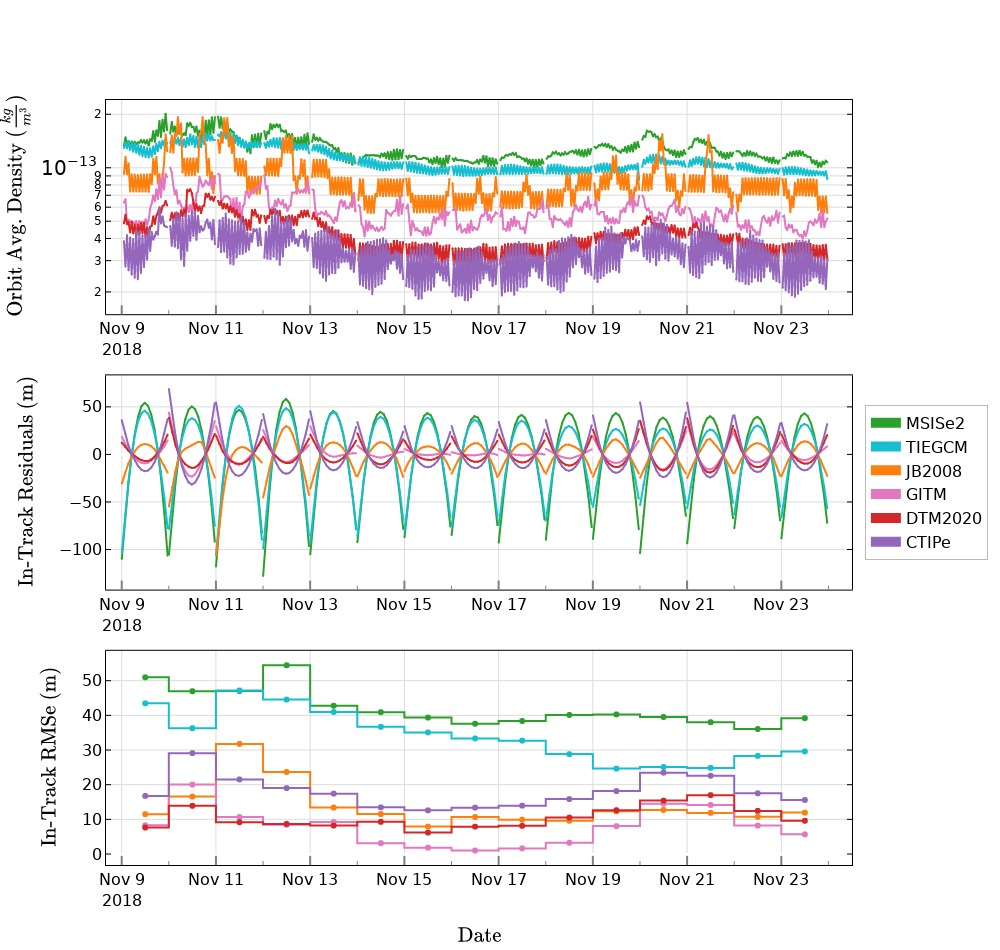

In [7]:
%load_ext autoreload
%autoreload 2



if STAGE == '2_RunGEODYN_with_PhysicalFixedCD':



    def plot_all_nokp(fig, obj_m1, plot_num,     arc_listlist ):


        ####  Get plot Parameters for this model
        model_m1 = obj_m1.__dict__['global_params']['den_model']
        col = get_plot_params(plot_num, model_m1)

        #### -----------------------------------------------------------------------------------------------------

    #### Arc Background 

        for i1,arc1 in enumerate(arc_listlist):#obj_m1.__dict__['global_params']['arc_input']):
            dateplot = []
            rms_totals = []

            for ii,arc in enumerate(arc1):#obj_m1.__dict__['global_params']['arc_input']):
                if arc not in obj_m1.__dict__['global_params']['arc_input']:
                    continue
                else:
                    arc =arc+'.01'

                    dateplot.append(pd.to_datetime(datetime.datetime(int(arc.split('.')[0]), 1, 1) + datetime.timedelta(int(arc.split('.')[1]))- datetime.timedelta(hours=12) ))
                    rms_totals.append(obj_m1.__dict__['Statistics'][arc]['T_RMS'].values[0])

                    ### -----------------------------------------------------------------------------------------------------
                    ###     DENSITY
                    ###
                    ## Remove the denisty file duplication
                    vals  = np.arange(obj_m1.__dict__['Density'][arc].index[0],obj_m1.__dict__['Density'][arc].index[-1]+1)
                    df = obj_m1.__dict__['Density'][arc].set_index('Date',drop=False ) 
                    df['i_vals'] = vals
                    index_date = df.loc[df.index.max()]['i_vals'].min()
                    time_avg,d_avg, d_avg_rolling = orb_avg(obj_m1.Density, arc)

                    ### -----------------------------------------------------------------------------------------------------
                    ###     Orbit Averaged Density
                    fig.add_trace(go.Scatter(x=time_avg,
                                               y=d_avg,
                                               ### name= model_m1,
                                               mode='markers+lines',
                                               opacity=1,
                                                   marker=dict(color=col,size=2),
                                               ###     line = dict( color = col, width=2),
#                                                    line = dict(shape='hvh', dash ='solid', color = col, width=2),
                                                   line = dict(dash ='solid', color = col, width=2),
                                               showlegend=False), row=1, col=1)
    #                 fig.add_trace(go.Scatter(x=obj_m1.__dict__['Density'][arc]['Date'][::50],
    #                                            y=obj_m1.__dict__['Density'][arc]['rho (kg/m**3)'][::50],
    #                                            ### name= model_m1,
    #                                            mode='lines',
    #                                            opacity=0.2,
    #                                                marker=dict(color=col,size=2),
    #                                            ###     line = dict( color = col, width=2),
    #                                                line = dict(dash ='solid', color = col, width=2),
    #                                            showlegend=False), row=1, col=1)

                    ### -----------------------------------------------------------------------------------------------------
                    ###     In Track Residuals
                    data_resids = obj_m1.__dict__['OrbitResids'][arc]['resids']
                    fig.add_trace(go.Scatter(x=data_resids['Date'][::50],
                                               y=data_resids['T'][::50],
                                               ###   name= model_m1,
                                                 mode='markers+lines',
                                                 opacity=1,
                                                     marker=dict(color=col,size=2),
                                                     line = dict( color = col, width=2),
                                                 showlegend=False),
                                                 secondary_y=False, row=2, col=1)
                ### -----------------------------------------------------------------------------------------------------
                ###     TOTAL RMS
    #             print(rms_totals)
                if ii == 14:
                    print(model_m1, "mean rms_totals",np.mean(rms_totals))

            fig.add_trace(go.Scatter(x=dateplot,
                                       y=rms_totals,
                                           ###e= 'NTW '+model_m1,
                                       mode='markers+lines',
                                             opacity=1,
                                             marker=dict(color=col,size=6),
                                             line = dict(shape='hvh', dash ='solid', color = col, width=2),
                                       showlegend=False),row=3, col=1)





    # full_fig = fig.full_figure_for_development()

        if plot_num == 2 or plot_num == 0:
            ###
            ### DENSITY AXIS
            fig.update_yaxes(title_text=r"$\text{Orbit Avg. Density } (\frac{kg}{m^3})$", 
                             type="log", 
    #                          range=yaxis2_range, 
                             exponentformat= 'power',row=1, col=1)
            ###
            ### InTrack Residual Axis
            fig.update_yaxes( title=r"$\text{In-Track Residuals (m)}$",
    #                          range=yaxis3_range, 
                             exponentformat= 'power',row=2, col=1)
            ###
            ### RMS AXIS
            fig.update_yaxes( title=r"$\text{In-Track RMSe (m)}$" ,type="linear" , exponentformat= 'power',
    #                           range=yaxis4_range, 
                             row=3, col=1)
            ###
            ###  DATE on Final x-Axis only
            fig.update_xaxes(title=r"$\text{Date}$", 
                             range=[pd.to_datetime( "181108-160000", format='%y%m%d-%H%M%S'),
                                    pd.to_datetime( "181124-120000", format='%y%m%d-%H%M%S')],
                             row=3, col=1)


        return(fig)





        ### -----------------------------------------------------------------------------------------------------
        ### -----------------------------------------------------------------------------------------------------
        ### -----------------------------------------------------------------------------------------------------
        ### -----------------------------------------------------------------------------------------------------
        ### -----------------------------------------------------------------------------------------------------




    #################################################################################
    #################################################################################
    #################################################################################
    #################################################################################
#                'msis2'      ,   
#                'tiegcm_oc'  ,
#                'jb2008'     ,
#                'hasdm_oc'   ,
#                'gitm'       ,           
#                'dtm2020_o'  ,
#                'ctipe_oc'   ,
    run_dict = { 
                  'msis2'    : 5   ,
                  'tiegcm_oc': 0  ,
                  'jb2008'   : 1   ,
#                   'hasdm_oc' : 0  , 
                  'gitm' :  3, 
                  'dtm2020_o'  : 3   ,
                  'ctipe_oc' : 4 ,
               }

    fig = make_subplots(rows=3, cols=1,
    #                     subplot_titles=([ ' ', ]),
                        #                     
                        specs=[#[ {"secondary_y": True} ],
                               [ {"secondary_y": False} ],
                               [ {"secondary_y": False} ],
                               [ {"secondary_y": False} ]],
                        #
                        vertical_spacing = 0.08,
                        shared_xaxes=True)




    for model in run_dict.keys():
        fig = plot_all_nokp(fig, Obj_Geodyn[model],  run_dict[model], arc_listlist)


    #######################################################
    font_dict=dict(family='Arial',size=16,color='black')
    #######################################################




    for i in [1,2,3]:
        fig.update_xaxes(### LINE at axis border
                          showline=True,
                          showticklabels=True,
                          linecolor='black',
                          linewidth=1,
                         ### Major ticks
                          ticks='inside',
                          tickfont=font_dict,
                          mirror=True,
                          tickwidth=2,
                          ticklen=9,
                          tickcolor='grey',
                          tick0="2018-11-9" ,
                          dtick=86400000.0*2,    # milliseconds in a day, every 7 days
                          #### Minor Ticks
                           minor=dict(
                             dtick=86400000.0, # milliseconds in a day
                             tickwidth=1,
                             ticklen=4,
                             tickcolor='grey',
                             ticks='inside'),
                          ### GRID
                           gridcolor='gainsboro',
                           gridwidth=1,
                           layer='above traces',
                           tickangle=0,
                           row=i, col=1)
        fig.update_yaxes(showline=True,      # add line at x=0
                             showticklabels=True,
                             linecolor='black',  # line color
                             linewidth=1,        # line size
                         ticks='inside',     # ticks outside axis
                         tickfont=font_dict, # tick label font
                         mirror='allticks',  # add ticks to top/right axes
                         tickwidth=1,      # tick width
                         tickcolor='black',  # tick color
                         gridcolor='gainsboro',
                         gridwidth=1,
                         layer='above traces',
                         row=i, col=1)


    modelnames=[]
    modelcolors = []
    #### LEGEND ####
    for model in run_dict.keys():
        if model == 'msis2':
            modelnames.append("MSISe2")
            modelcolors.append(col_msis2)

        elif model == 'dtm2020_o':
            modelnames.append("DTM2020")
            modelcolors.append(col_dtm2020)

        elif model == 'jb2008':
            modelnames.append("JB2008")
            modelcolors.append(col_jb2008)

        elif model == 'tiegcm_oc':
            modelnames.append("TIEGCM")
            modelcolors.append(col_tiegcm_oc)

        elif model == 'hasdm_oc':
            modelnames.append("HASDM")
            modelcolors.append(col_hasdm_oc)

        elif model == 'ctipe_oc':
            modelnames.append("CTIPe")
            modelcolors.append(col_ctipe_oc)

        elif model == 'gitm':
            modelnames.append("GITM")
            modelcolors.append(col_gitm)



    df = pd.DataFrame({"starts_colors": modelcolors
                                        })

    fig.update_traces(showlegend=False).add_traces(
        [   go.Scattergl(name=modelnames[i], 
                   x=[pd.to_datetime( "181107-000000", format='%y%m%d-%H%M%S')],
                   mode='lines',
                   line = dict(shape = 'hv',  width=10),
                   marker_color=c, 
                   showlegend=True)
            for i,c in enumerate((df.loc[:,["starts_colors"]].values.ravel()))])

    fig.update_layout(legend=dict(
        yanchor="middle",
        y=0.5,
        xanchor="center",
        x=1.1,
    #     x=1.015,
            font=font_dict      ,
            bgcolor="white",
            bordercolor="darkgrey",
            borderwidth=0.8,
        )  )

    fig.update_layout(
    #                   title = '',
                      autosize=False,    width=1000,    height=950,
                      legend= {'itemsizing': 'trace'},
                      font=font_dict,
                      plot_bgcolor='white', 
                     )
    fig.update_annotations(font_size=14)  # Increase size of subplot title

    fig.show(renderer="jpg",
             config=dict({
                'displayModeBar': False,
                'responsive': False,
                'staticPlot': True,
                'displaylogo': False,
                'showTips': False,
                }))

    
    if save_plot_flag:
        pio.write_image(fig, plot_dir+'Assessment_CD2.5.jpg', scale=3)




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
msis2 mean rms_totals 42.10795312600123
tiegcm_oc mean rms_totals 34.10922509237534
jb2008 mean rms_totals 13.742583359362726
hasdm_oc mean rms_totals 8.184339119118018
gitm mean rms_totals 7.870307550064461
dtm2020_o mean rms_totals 10.44636458091468
ctipe_oc mean rms_totals 18.02509090026523


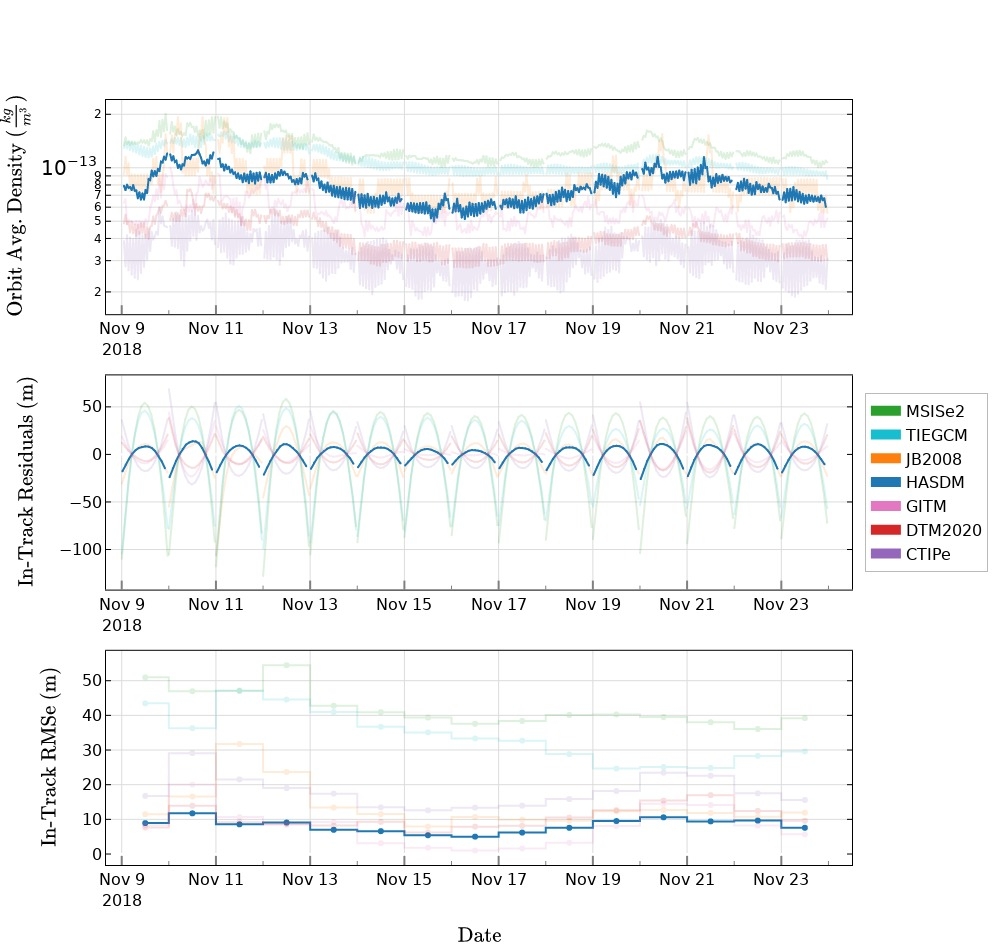

In [8]:
%load_ext autoreload
%autoreload 2



if STAGE == '2_RunGEODYN_with_PhysicalFixedCD':



    def plot_all_nokp(fig, obj_m1, plot_num,     arc_listlist ):


        ####  Get plot Parameters for this model
        model_m1 = obj_m1.__dict__['global_params']['den_model']
        col = get_plot_params(plot_num, model_m1)

        
        if model!='hasdm_oc':
            opac_val = 0.15
        else:
            opac_val = 1

        
    #### Arc Background 

        for i1,arc1 in enumerate(arc_listlist):#obj_m1.__dict__['global_params']['arc_input']):
            dateplot = []
            rms_totals = []

            for ii,arc in enumerate(arc1):#obj_m1.__dict__['global_params']['arc_input']):
                if arc not in obj_m1.__dict__['global_params']['arc_input']:
                    continue
                else:
                    arc =arc+'.01'

                    dateplot.append(pd.to_datetime(datetime.datetime(int(arc.split('.')[0]), 1, 1) + datetime.timedelta(int(arc.split('.')[1]))- datetime.timedelta(hours=12) ))
                    rms_totals.append(obj_m1.__dict__['Statistics'][arc]['T_RMS'].values[0])

                    ### -----------------------------------------------------------------------------------------------------
                    ###     DENSITY
                    ###
                    ## Remove the denisty file duplication
                    vals  = np.arange(obj_m1.__dict__['Density'][arc].index[0],obj_m1.__dict__['Density'][arc].index[-1]+1)
                    df = obj_m1.__dict__['Density'][arc].set_index('Date',drop=False ) 
                    df['i_vals'] = vals
                    index_date = df.loc[df.index.max()]['i_vals'].min()
                    time_avg,d_avg, d_avg_rolling = orb_avg(obj_m1.Density, arc)

                    ### -----------------------------------------------------------------------------------------------------
                    ###     Orbit Averaged Density
                    fig.add_trace(go.Scatter(x=time_avg,
                                               y=d_avg,
                                               ### name= model_m1,
                                               mode='markers+lines',
                                               opacity=opac_val,
                                                   marker=dict(color=col,size=2),
                                               ###     line = dict( color = col, width=2),
#                                                    line = dict(shape='hvh', dash ='solid', color = col, width=2),
                                                   line = dict(dash ='solid', color = col, width=2),
                                               showlegend=False), row=1, col=1)
    #                 fig.add_trace(go.Scatter(x=obj_m1.__dict__['Density'][arc]['Date'][::50],
    #                                            y=obj_m1.__dict__['Density'][arc]['rho (kg/m**3)'][::50],
    #                                            ### name= model_m1,
    #                                            mode='lines',
    #                                            opacity=0.2,
    #                                                marker=dict(color=col,size=2),
    #                                            ###     line = dict( color = col, width=2),
    #                                                line = dict(dash ='solid', color = col, width=2),
    #                                            showlegend=False), row=1, col=1)

                    ### -----------------------------------------------------------------------------------------------------
                    ###     In Track Residuals
                    data_resids = obj_m1.__dict__['OrbitResids'][arc]['resids']
                    fig.add_trace(go.Scatter(x=data_resids['Date'][::50],
                                               y=data_resids['T'][::50],
                                               ###   name= model_m1,
                                                 mode='markers+lines',
                                                 opacity=opac_val,
                                                     marker=dict(color=col,size=2),
                                                     line = dict( color = col, width=2),
                                                 showlegend=False),
                                                 secondary_y=False, row=2, col=1)
                ### -----------------------------------------------------------------------------------------------------
                ###     TOTAL RMS
    #             print(rms_totals)
                if ii == 14:
                    print(model_m1, "mean rms_totals",np.mean(rms_totals))

            fig.add_trace(go.Scatter(x=dateplot,
                                       y=rms_totals,
                                           ###e= 'NTW '+model_m1,
                                       mode='markers+lines',
                                             opacity=opac_val,
                                             marker=dict(color=col,size=6),
                                             line = dict(shape='hvh', dash ='solid', color = col, width=2),
                                       showlegend=False),row=3, col=1)





    # full_fig = fig.full_figure_for_development()

        if plot_num == 2 or plot_num == 0:
            ###
            ### DENSITY AXIS
            fig.update_yaxes(title_text=r"$\text{Orbit Avg. Density } (\frac{kg}{m^3})$", 
                             type="log", 
    #                          range=yaxis2_range, 
                             exponentformat= 'power',row=1, col=1)
            ###
            ### InTrack Residual Axis
            fig.update_yaxes( title=r"$\text{In-Track Residuals (m)}$",
    #                          range=yaxis3_range, 
                             exponentformat= 'power',row=2, col=1)
            ###
            ### RMS AXIS
            fig.update_yaxes( title=r"$\text{In-Track RMSe (m)}$" ,type="linear" , exponentformat= 'power',
    #                           range=yaxis4_range, 
                             row=3, col=1)
            ###
            ###  DATE on Final x-Axis only
            fig.update_xaxes(title=r"$\text{Date}$", 
                             range=[pd.to_datetime( "181108-160000", format='%y%m%d-%H%M%S'),
                                    pd.to_datetime( "181124-120000", format='%y%m%d-%H%M%S')],
                             row=3, col=1)


        return(fig)





        ### -----------------------------------------------------------------------------------------------------
        ### -----------------------------------------------------------------------------------------------------
        ### -----------------------------------------------------------------------------------------------------
        ### -----------------------------------------------------------------------------------------------------
        ### -----------------------------------------------------------------------------------------------------




    #################################################################################
    #################################################################################
    #################################################################################
    #################################################################################

    run_dict = { 
                  'msis2'    : 5   ,
                  'tiegcm_oc': 0  ,
                  'jb2008'   : 1   ,
                  'hasdm_oc' : 0  , 
                  'gitm' :  3, 
                  'dtm2020_o'  : 3   ,
                  'ctipe_oc' : 4 ,
               }

    fig = make_subplots(rows=3, cols=1,
    #                     subplot_titles=([ ' ', ]),
                        #                     
                        specs=[#[ {"secondary_y": True} ],
                               [ {"secondary_y": False} ],
                               [ {"secondary_y": False} ],
                               [ {"secondary_y": False} ]],
                        #
                        vertical_spacing = 0.08,
                        shared_xaxes=True)




    for model in run_dict.keys():
        fig = plot_all_nokp(fig, Obj_Geodyn[model],  run_dict[model], arc_listlist)


    #######################################################
    font_dict=dict(family='Arial',size=16,color='black')
    #######################################################




    for i in [1,2,3]:
        fig.update_xaxes(### LINE at axis border
                          showline=True,
                          showticklabels=True,
                          linecolor='black',
                          linewidth=1,
                         ### Major ticks
                          ticks='inside',
                          tickfont=font_dict,
                          mirror=True,
                          tickwidth=2,
                          ticklen=9,
                          tickcolor='grey',
                          tick0="2018-11-9" ,
                          dtick=86400000.0*2,    # milliseconds in a day, every 7 days
                          #### Minor Ticks
                           minor=dict(
                             dtick=86400000.0, # milliseconds in a day
                             tickwidth=1,
                             ticklen=4,
                             tickcolor='grey',
                             ticks='inside'),
                          ### GRID
                           gridcolor='gainsboro',
                           gridwidth=1,
                           layer='above traces',
                           tickangle=0,
                           row=i, col=1)
        fig.update_yaxes(showline=True,      # add line at x=0
                             showticklabels=True,
                             linecolor='black',  # line color
                             linewidth=1,        # line size
                         ticks='inside',     # ticks outside axis
                         tickfont=font_dict, # tick label font
                         mirror='allticks',  # add ticks to top/right axes
                         tickwidth=1,      # tick width
                         tickcolor='black',  # tick color
                         gridcolor='gainsboro',
                         gridwidth=1,
                         layer='above traces',
                         row=i, col=1)


    modelnames=[]
    modelcolors = []
    #### LEGEND ####
    for model in run_dict.keys():
        if model == 'msis2':
            modelnames.append("MSISe2")
            modelcolors.append(col_msis2)

        elif model == 'dtm2020_o':
            modelnames.append("DTM2020")
            modelcolors.append(col_dtm2020)

        elif model == 'jb2008':
            modelnames.append("JB2008")
            modelcolors.append(col_jb2008)

        elif model == 'tiegcm_oc':
            modelnames.append("TIEGCM")
            modelcolors.append(col_tiegcm_oc)

        elif model == 'hasdm_oc':
            modelnames.append("HASDM")
            modelcolors.append(col_hasdm_oc)

        elif model == 'ctipe_oc':
            modelnames.append("CTIPe")
            modelcolors.append(col_ctipe_oc)

        elif model == 'gitm':
            modelnames.append("GITM")
            modelcolors.append(col_gitm)



    df = pd.DataFrame({"starts_colors": modelcolors
                                        })

    fig.update_traces(showlegend=False).add_traces(
        [   go.Scattergl(name=modelnames[i], 
                   x=[pd.to_datetime( "181107-000000", format='%y%m%d-%H%M%S')],
                   mode='lines',
                   line = dict(shape = 'hv',  width=10),
                   marker_color=c, 
                   showlegend=True)
            for i,c in enumerate((df.loc[:,["starts_colors"]].values.ravel()))])

    fig.update_layout(legend=dict(
        yanchor="middle",
        y=0.5,
        xanchor="center",
        x=1.1,
    #     x=1.015,
            font=font_dict      ,
            bgcolor="white",
            bordercolor="darkgrey",
            borderwidth=0.8,
        )  )

    fig.update_layout(
    #                   title = '',
                      autosize=False,    width=1000,    height=950,
                      legend= {'itemsizing': 'trace'},
                      font=font_dict,
                      plot_bgcolor='white', 
                     )
    fig.update_annotations(font_size=14)  # Increase size of subplot title

    fig.show(renderer="jpg",
             config=dict({
                'displayModeBar': False,
                'responsive': False,
                'staticPlot': True,
                'displaylogo': False,
                'showTips': False,
                }))

#     pio.write_image(fig, plot_dir+'Assessment_CD2.5.jpg', scale=3)
    if save_plot_flag:
        pio.write_image(fig, plot_dir+'VerifyHASDM_CD2.5.jpg', scale=3)




## Stage 5 Plot

In [9]:
Obj_Geodyn[model].__dict__['global_params']['run_settings']['cd_value']

2.5

In [10]:
%load_ext autoreload
%autoreload 2



if STAGE == '5_RunGEODYN_FixedMeanCD':



    def plot_all_nokp(fig, obj_m1, plot_num,     arc_listlist ):

        cd_apriori  = 2.5
        cd_adjusted = obj_m1.__dict__['global_params']['run_settings']['cd_value']

        ####  Get plot Parameters for this model
        model_m1 = obj_m1.__dict__['global_params']['den_model']
        col = get_plot_params(plot_num, model_m1)

        #### -----------------------------------------------------------------------------------------------------

    #### Arc Background 

        for i1,arc1 in enumerate(arc_listlist):#obj_m1.__dict__['global_params']['arc_input']):
            dateplot = []
            rms_totals = []

            for ii,arc in enumerate(arc1):#obj_m1.__dict__['global_params']['arc_input']):
                if arc not in obj_m1.__dict__['global_params']['arc_input']:
                    continue
                else:
                    arc =arc+'.01'

                    dateplot.append(pd.to_datetime(datetime.datetime(int(arc.split('.')[0]), 1, 1) + datetime.timedelta(int(arc.split('.')[1]))- datetime.timedelta(hours=12) ))
                    rms_totals.append(obj_m1.__dict__['Statistics'][arc]['T_RMS'].values[0])

                    ### -----------------------------------------------------------------------------------------------------
                    ###     DENSITY
                    ###
                    ## Remove the denisty file duplication
                    vals  = np.arange(obj_m1.__dict__['Density'][arc].index[0],obj_m1.__dict__['Density'][arc].index[-1]+1)
                    df = obj_m1.__dict__['Density'][arc].set_index('Date',drop=False ) 
                    df['i_vals'] = vals
                    index_date = df.loc[df.index.max()]['i_vals'].min()
                    time_avg,d_avg, d_avg_rolling = orb_avg(obj_m1.Density, arc)

                    ### -----------------------------------------------------------------------------------------------------
                    ###     Orbit Averaged Density
                    fig.add_trace(go.Scatter(x=time_avg,
                                               y=d_avg*(cd_adjusted/cd_apriori),
                                               ### name= model_m1,
                                               mode='markers+lines',
                                               opacity=1,
                                                   marker=dict(color=col,size=2),
                                               ###     line = dict( color = col, width=2),
#                                                    line = dict(shape='hvh', dash ='solid', color = col, width=2),
                                                   line = dict(dash ='solid', color = col, width=2),
                                               showlegend=False), row=1, col=1)
                    fig.add_trace(go.Scatter(x=time_avg,
                                           y=d_avg,
                                           ### name= model_m1,
                                           mode='markers+lines',
                                           opacity=0.3,
                                               marker=dict(color=col,size=2),
#                                                line = dict( color = col, width=2),
                                               line = dict(shape='hvh', dash ='dot', color = col, width=2),
                                           showlegend=False), row=1, col=1)            
    #                 fig.add_trace(go.Scatter(x=obj_m1.__dict__['Density'][arc]['Date'][::50],
    #                                            y=obj_m1.__dict__['Density'][arc]['rho (kg/m**3)'][::50],
    #                                            ### name= model_m1,
    #                                            mode='lines',
    #                                            opacity=0.2,
    #                                                marker=dict(color=col,size=2),
    #                                            ###     line = dict( color = col, width=2),
    #                                                line = dict(dash ='solid', color = col, width=2),
    #                                            showlegend=False), row=1, col=1)

                    ### -----------------------------------------------------------------------------------------------------
                    ###     In Track Residuals
                    data_resids = obj_m1.__dict__['OrbitResids'][arc]['resids']
                    fig.add_trace(go.Scatter(x=data_resids['Date'][::50],
                                               y=data_resids['T'][::50],
                                               ###   name= model_m1,
                                                 mode='markers+lines',
                                                 opacity=1,
                                                     marker=dict(color=col,size=2),
                                                     line = dict( color = col, width=2),
                                                 showlegend=False),
                                                 secondary_y=False, row=2, col=1)
                ### -----------------------------------------------------------------------------------------------------
                ###     TOTAL RMS
    #             print(rms_totals)
                if ii == 14:
#                     print(model_m1, "mean rms_totals:         ",np.round(np.mean(rms_totals),3) )
#                     print('       density scaling factor: ', np.round((cd_adjusted/cd_apriori),3))
                    print(model_m1 )
                    print("   mean rms_totals:       ",np.round(np.mean(rms_totals),3) )
                    print('   density scaling factor:', np.round((cd_adjusted/cd_apriori),3))
            fig.add_trace(go.Scatter(x=dateplot,
                                       y=rms_totals,
                                           ###e= 'NTW '+model_m1,
                                       mode='markers+lines',
                                             opacity=1,
                                             marker=dict(color=col,size=6),
                                             line = dict(shape='hvh', dash ='solid', color = col, width=2),
                                       showlegend=False),row=3, col=1)





    # full_fig = fig.full_figure_for_development()

        if plot_num == 2 or plot_num == 0:
            ###
            ### DENSITY AXIS
            fig.update_yaxes(title_text=r"$\text{Orbit Avg. Density } (\frac{kg}{m^3})$", 
                             type="log", 
    #                          range=yaxis2_range, 
                             exponentformat= 'power',row=1, col=1)
            ###
            ### InTrack Residual Axis
            fig.update_yaxes( title=r"$\text{In-Track Residuals (m)}$",
    #                          range=yaxis3_range, 
                             exponentformat= 'power',row=2, col=1)
            ###
            ### RMS AXIS
            fig.update_yaxes( title=r"$\text{In-Track RMSe (m)}$" ,type="linear" , exponentformat= 'power',
    #                           range=yaxis4_range, 
                             row=3, col=1)
            ###
            ###  DATE on Final x-Axis only
            fig.update_xaxes(title=r"$\text{Date}$", 
                             range=[pd.to_datetime( "181108-160000", format='%y%m%d-%H%M%S'),
                                    pd.to_datetime( "181124-120000", format='%y%m%d-%H%M%S')],
                             row=3, col=1)


        return(fig)





        ### -----------------------------------------------------------------------------------------------------
        ### -----------------------------------------------------------------------------------------------------
        ### -----------------------------------------------------------------------------------------------------
        ### -----------------------------------------------------------------------------------------------------
        ### -----------------------------------------------------------------------------------------------------




    #################################################################################
    #################################################################################
    #################################################################################
    #################################################################################

    run_dict = { 
                  'msis2'    : 5   ,
                  'tiegcm_oc': 0  ,
                  'jb2008'   : 1   ,
                  'gitm' :  3, 
                  'dtm2020_o'  : 3   ,
                'ctipe_oc' : 4 ,
                  'hasdm_oc' : 0  , 
               }

    fig = make_subplots(rows=3, cols=1,
    #                     subplot_titles=([ ' ', ]),
                        #                     
                        specs=[#[ {"secondary_y": True} ],
                               [ {"secondary_y": False} ],
                               [ {"secondary_y": False} ],
                               [ {"secondary_y": False} ]],
                        #
                        vertical_spacing = 0.08,
                        shared_xaxes=True)




    for model in run_dict.keys():
        fig = plot_all_nokp(fig, Obj_Geodyn[model],  run_dict[model], arc_listlist)


    #######################################################
    font_dict=dict(family='Arial',size=16,color='black')
    #######################################################




    for i in [1,2,3]:
        fig.update_xaxes(### LINE at axis border
                          showline=True,
                          showticklabels=True,
                          linecolor='black',
                          linewidth=1,
                         ### Major ticks
                          ticks='inside',
                          tickfont=font_dict,
                          mirror=True,
                          tickwidth=2,
                          ticklen=9,
                          tickcolor='grey',
                          tick0="2018-11-9" ,
                          dtick=86400000.0*2,    # milliseconds in a day, every 7 days
                          #### Minor Ticks
                           minor=dict(
                             dtick=86400000.0, # milliseconds in a day
                             tickwidth=1,
                             ticklen=4,
                             tickcolor='grey',
                             ticks='inside'),
                          ### GRID
                           gridcolor='gainsboro',
                           gridwidth=1,
                           layer='above traces',
                           tickangle=0,
                           row=i, col=1)
        fig.update_yaxes(showline=True,      # add line at x=0
                             showticklabels=True,
                             linecolor='black',  # line color
                             linewidth=1,        # line size
                         ticks='inside',     # ticks outside axis
                         tickfont=font_dict, # tick label font
                         mirror='allticks',  # add ticks to top/right axes
                         tickwidth=1,      # tick width
                         tickcolor='black',  # tick color
                         gridcolor='gainsboro',
                         gridwidth=1,
                         layer='above traces',
                         row=i, col=1)


    modelnames=[]
    modelcolors = []
    #### LEGEND ####
    for model in run_dict.keys():
        if model == 'msis2':
            modelnames.append("MSISe2")
            modelcolors.append(col_msis2)

        elif model == 'dtm2020_o':
            modelnames.append("DTM2020")
            modelcolors.append(col_dtm2020)

        elif model == 'jb2008':
            modelnames.append("JB2008")
            modelcolors.append(col_jb2008)

        elif model == 'tiegcm_oc':
            modelnames.append("TIEGCM")
            modelcolors.append(col_tiegcm_oc)

        elif model == 'hasdm_oc':
            modelnames.append("HASDM")
            modelcolors.append(col_hasdm_oc)

        elif model == 'ctipe_oc':
            modelnames.append("CTIPe")
            modelcolors.append(col_ctipe_oc)

        elif model == 'gitm':
            modelnames.append("GITM")
            modelcolors.append(col_gitm)



    df = pd.DataFrame({"starts_colors": modelcolors
                                        })

    fig.update_traces(showlegend=False).add_traces(
        [   go.Scattergl(name=modelnames[i], 
                   x=[pd.to_datetime( "181107-000000", format='%y%m%d-%H%M%S')],
                   mode='lines',
                   line = dict(shape = 'hv',  width=10),
                   marker_color=c, 
                   showlegend=True)
            for i,c in enumerate((df.loc[:,["starts_colors"]].values.ravel()))])

    fig.update_layout(legend=dict(
        yanchor="middle",
        y=0.5,
        xanchor="center",
        x=1.1,
    #     x=1.015,
            font=font_dict      ,
            bgcolor="white",
            bordercolor="darkgrey",
            borderwidth=0.8,
        )  )

    fig.update_layout(
    #                   title = '',
                      autosize=False,    width=1000,    height=950,
                      legend= {'itemsizing': 'trace'},
                      font=font_dict,
                      plot_bgcolor='white', 
                     )
    fig.update_annotations(font_size=14)  # Increase size of subplot title

    fig.show(renderer="jpg",
             config=dict({
                'displayModeBar': False,
                'responsive': False,
                'staticPlot': True,
                'displaylogo': False,
                'showTips': False,
                }))

    if save_plot_flag:
        pio.write_image(fig, plot_dir+'Assessment_CDAvgAdj.jpg', scale=3)




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Print RMS tables by Kp

In [11]:
from netCDF4 import Dataset
def read_nc_file( filename, variables):
    ''' This function reads the TIEGCM .nc files and saves the given input variables to a dictionary.
        The breakloop feature is here so that if the file doesn't exist the code can still continue.  '''
    status = os.path.exists(filename)
    
    if status == True:
        data = {}
        for i, var_names in enumerate(variables):
            ncid =  Dataset(filename,"r+", format="NETCDF4")# filename must be a string
            varData = ncid.variables
            data[var_names] = np.array(varData[var_names])  
    elif status == False:
        print('No File Found', filename )
        breakloop = True
        data = 0
        return( data , breakloop)
    breakloop = False
    return(data,breakloop )


arc_list = []

arc_list_18 = np.arange(292,366)
for i in arc_list_18:
    val = '2018'+str(i)
    arc_list.append(int(val))
    
    #     print(val)
    
arc_list_19 = np.arange(1,10)
for i in arc_list_19:
    val = '201900'+str(i)
    arc_list.append(int(val))


path_to_f107 = '/data/data_geodyn/gpi_1960001-2021243_f107aDaily.nc'
variables = ['year_day', 'f107d', 'f107a', 'kp']
f107_data = read_nc_file(path_to_f107, variables)

date = []
kp_list = []
f107d_list = []
f107a_list  = []
date_3hr = []


for i,val in enumerate(arc_list):
    
    index = f107_data[0]['year_day']==val
    kp_list.append(f107_data[0]['kp'][index][0])
    f107d_list.append(f107_data[0]['f107d'][index][0])
    f107a_list.append(f107_data[0]['f107a'][index][0])
    
    date.append(pd.to_datetime( str(val), format='%Y%j'))

    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=0))
    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=3))
    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=6))
    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=9))
    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=12))
    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=15))
    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=18))
    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=21))
#     date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=24))
    
kp_expand = []
for i in kp_list:
    for ii in i:
        kp_expand.append(ii)
        
        
        
solar_fluxes = {}
solar_fluxes['f107d_list'] = f107d_list
solar_fluxes['f107a_list'] = f107a_list
solar_fluxes['date']       = date
solar_fluxes['date_3hr']   = date_3hr
solar_fluxes['kp_expand']  = kp_expand


### Prepare RMS total Plot arrays

arc_listlist=[  ['2018.292', '2018.293', '2018.294', '2018.295', '2018.296', 
                 '2018.297', '2018.298', '2018.299' ],                  
                #
                ['2018.304', '2018.305', '2018.306', '2018.307', '2018.308' ],  
                #
                ['2018.313', '2018.314', '2018.315', '2018.316', '2018.317',
                 '2018.318', '2018.319', '2018.320', '2018.321', '2018.322',
                 '2018.323', '2018.324', '2018.325', '2018.326', '2018.327' ],  
                #
                ['2018.335', '2018.336', '2018.337' ],  
                #
                ['2018.349', '2018.350', '2018.351', '2018.352' ],  
                #
                ['2018.356', '2018.357', '2018.358' ],  
                #
                ['2018.365', '2019.001', '2019.002', '2019.003', '2019.004', 
                 '2019.005', '2019.006', '2019.007', '2019.008',
                '2019.009'],  
                ]




index1 = 21
index2 = 37
index3h_1 = 168
index3h_2 = 289

# for i, date in enumerate(solar_fluxes['date_3hr'][index3h_1:index3h_2]):
#     if solar_fluxes['kp_expand'][index3h_1:index3h_2][i] >= 3.0:
#         print(date)

# %load_ext autoreload
# %autoreload 2




def get_meanRMS_for_geomag( obj_m1, plot_num, solar_fluxes,    arc_listlist ):
    
    cd_apriori  = 2.5
    cd_adjusted = obj_m1.__dict__['global_params']['run_settings']['cd_value']

    ####  Get plot Parameters for this model
    model_m1 = obj_m1.__dict__['global_params']['den_model']
    col = get_plot_params(plot_num, model_m1)
    
    if plot_num == 2 or plot_num == 0:
        index1 = 21
        index2 = 37
        index3h_1 = 168
        index3h_2 = 289
#         solar_fluxes['date'][index1:index2]
#         solar_fluxes['date_3hr'][index3h_1:index3h_2]
#         solar_fluxes['kp_expand'][index3h_1:index3h_2]
        





#### Arc Background 
    mean_rms_totals = []
    
    high_geomag_arcs = ['2018.313.01','2018.314.01','2018.315.01','2018.316.01','2018.324.01']

    mean_rms_totals_high = []
    mean_rms_totals_low = []
    for i1,arc1 in enumerate(arc_listlist):#obj_m1.__dict__['global_params']['arc_input']):
        dateplot = []
        rms_totals_high = []
        rms_totals_low = []
        
        for ii,arc in enumerate(arc1):#obj_m1.__dict__['global_params']['arc_input']):
            if arc not in obj_m1.__dict__['global_params']['arc_input']:
                continue
            else:
                arc =arc+'.01'

                dateplot.append(pd.to_datetime(datetime.datetime(int(arc.split('.')[0]), 1, 1) + datetime.timedelta(int(arc.split('.')[1]))- datetime.timedelta(hours=12) ))
                
                if arc in high_geomag_arcs:
                    rms_totals_high.append(obj_m1.__dict__['Statistics'][arc]['T_RMS'].values[0])
                else:
                    rms_totals_low.append(obj_m1.__dict__['Statistics'][arc]['T_RMS'].values[0])

#                 rms_totals.append(obj_m1.__dict__['Statistics'][arc]['T_RMS'].values[0])
                
                ### -----------------------------------------------------------------------------------------------------
                ###     DENSITY
                ###
                ## Remove the denisty file duplication
                vals  = np.arange(obj_m1.__dict__['Density'][arc].index[0],obj_m1.__dict__['Density'][arc].index[-1]+1)
                df = obj_m1.__dict__['Density'][arc].set_index('Date',drop=False ) 
                df['i_vals'] = vals
                index_date = df.loc[df.index.max()]['i_vals'].min()
                time_avg,d_avg, d_avg_rolling = orb_avg(obj_m1.Density, arc)


            
            if arc in high_geomag_arcs:
                mean_rms_totals_high.append(rms_totals_high)
            else:
                mean_rms_totals_low.append(rms_totals_low)

    print(model_m1)
    print('    HIGH: ', model_m1, np.round(np.mean(mean_rms_totals_high), 3))
    print('    LOW : ', model_m1, np.round(np.mean(mean_rms_totals_low), 3))
    
    

    return()







for model in run_dict.keys():
    fig = get_meanRMS_for_geomag(  Obj_Geodyn[model],  run_dict[model],  solar_fluxes, arc_listlist, )




### pio.write_image(fig, plots_dir+'twoweek_fullresult.pdf')

# pio.write_image(fig, plots_dir+'ScaledCD_density_and_metrics.jpg', scale=3)

    
    



msis2
    HIGH:  msis2 47.79
    LOW :  msis2 39.267
tiegcm_oc
    HIGH:  tiegcm_oc 39.322
    LOW :  tiegcm_oc 31.503
jb2008
    HIGH:  jb2008 19.247
    LOW :  jb2008 10.99
hasdm_oc
    HIGH:  hasdm_oc 9.776
    LOW :  hasdm_oc 7.388
gitm
    HIGH:  gitm 12.386
    LOW :  gitm 5.612
dtm2020_o
    HIGH:  dtm2020_o 10.964
    LOW :  dtm2020_o 10.188
ctipe_oc
    HIGH:  ctipe_oc 21.975
    LOW :  ctipe_oc 16.05


## Stage 3 and 4

In [12]:
if STAGE == '4_GetMeanCDfromAdjustment':


    satid = int(Obj_Geodyn['hasdm_oc'].__dict__['global_params']['SATID'])




    fig = make_subplots(rows=1, cols=1,
    #                     subplot_titles=([ ' ', ]),
                        #                     
                        specs=[[ {"secondary_y": False} ]],
                        #
                        vertical_spacing = 0.05,
                        shared_xaxes=True)

    for plot_num, model in enumerate(run_list):
        col = get_plot_params(plot_num, model)
        plot
        Cd_vals  = []
        Cd_times = []
        for iarc,valarc in enumerate(Obj_Geodyn[model].__dict__['global_params']['arc_input']):
            arc = valarc+'.01'
            iters = int(Obj_Geodyn[model].__dict__['run_parameters'+arc]['total_iterations'])

            for itime in Obj_Geodyn[model].__dict__['AdjustedParams'][arc][iters][satid]['0CD'].keys():
        #         print( Obj_Geodyn['msis2'].__dict__['AdjustedParams'][arc][iters][satid]['0CD'][itime]['CURRENT_VALUE'])
                Cd_vals.append(Obj_Geodyn[model].__dict__['AdjustedParams'][arc][iters][satid]['0CD'][itime]['CURRENT_VALUE'])
                Cd_times.append(itime)
        Cd_mean = np.mean(Cd_vals)
        print('MEAN CD FOR ',model, '-- Cd_mean=',np.round(Cd_mean,6),sep='')


        fig.add_hline(y=Cd_mean, line = dict(dash='dash', color = col, width=2),
                        )



        if model == 'msis2':
            modelname = "MSISe2"
            shift = -0.31
        elif model == 'dtm2020_o':
            modelname = "DTM2020"
            shift=.4
        elif model == 'jb2008':
            modelname = "JB2008"
            shift = .12
        elif model == 'tiegcm_oc':
            modelname = "TIEGCM"
            shift = 0.1
        elif model == 'hasdm_oc':
            modelname = "HASDM"
            shift = 0.5
        elif model == 'ctipe_oc':
            modelname = "CTIPe"
            shift = .3
        elif model == 'gitm':
            modelname = "GITM"
            shift = .1

        else:
            shift=0

        fig.add_annotation(
                    y= Cd_mean+shift,
    #                 x= 1.158,
                    x= 1.1,
                    xref="x domain", yref="y",
                    showarrow=False,
                    text=modelname+"<br>Mean CD="+str(np.round(Cd_mean,6)), 
                    align = 'left',
                    bgcolor='white',
                    bordercolor=col,
                    borderwidth=1.2,
                    borderpad=1.2,
                    font=font_annot,
                    )

        fig.add_trace(go.Scattergl(x=Cd_times,
                                   y=Cd_vals,
                                   name= model,
                                   mode='markers',
                                   opacity=0.8,
                                       marker=dict(color=col, size=10 ),
        #                            line = dict(shape = 'hvh', color = 'cornflowerblue', width=1.5),
                                   showlegend=False),
                                   secondary_y=False,row=1, col=1)


    # fig.add_hline(y=1.2367916759507616, line = dict(dash='dash', color = col_msis2, width=2))


    fig.update_xaxes(### LINE at axis border
                      showline=True,
                      showticklabels=True,
                      linecolor='black',
                      linewidth=1,
                     ### Major ticks
                      ticks='inside',
                      tickfont=font_dict,
                      mirror=True,
                      tickwidth=2,
                      ticklen=9,
                      tickcolor='grey',
                      tick0="2018-11-9" ,
                      dtick=86400000.0*2,    # milliseconds in a day, every 7 days
                      #### Minor Ticks
                       minor=dict(
                         dtick=86400000.0, # milliseconds in a day
                         tickwidth=1,
                         ticklen=4,
                         tickcolor='grey',
                         ticks='inside'),
                      ### GRID
                       gridcolor='gainsboro',
                       gridwidth=1,
                       layer='above traces',
                       tickangle=0,
                       row=1, col=1)
    fig.update_yaxes(showline=True,      # add line at x=0
                         showticklabels=True,
                         linecolor='black',  # line color
                         linewidth=1,        # line size
                     ticks='inside',     # ticks outside axis
                     tickfont=font_dict, # tick label font
                     mirror='allticks',  # add ticks to top/right axes
                     tickwidth=1,      # tick width
                     tickcolor='black',  # tick color
                     gridcolor='gainsboro',
                     gridwidth=1,
                     layer='above traces',
    #                  range=[1,5],
                     row=1, col=1)

            ###
    fig.update_yaxes( title=r"$\text{Adjusted CDs}$" ,type="linear" , exponentformat= 'power',
    #                           range=yaxis4_range, 
                     row=1, col=1)
    ###
    ###  DATE on Final x-Axis only
    fig.update_xaxes(title=r"$\text{Date}$", 
                     range=[pd.to_datetime( "181108-160000", format='%y%m%d-%H%M%S'),
                            pd.to_datetime( "181125-120000", format='%y%m%d-%H%M%S')],
                     row=1, col=1)



    fig.update_layout(
    #                   title = '',
                      autosize=False,    width=800,    height=500,
                      legend= {'itemsizing': 'trace'},
                      font=font_dict,
                      plot_bgcolor='white', 
                     )
    fig.update_annotations(font_size=14)  # Increase size of subplot title

    fig.show( config=config )



# Second